In [17]:
!pip install pycce
!pip install ase

Libraries

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import pycce as pc
import ase
from mpl_toolkits import mplot3d


### Setting up simulator object

Import the .xyz file

In [49]:
seed=8805
np.set_printoptions(suppress=True, precision=5)
#from https://pycce.readthedocs.io/en/latest/tutorials/diamond_nv.html
filename="ti.xyz"
xyz = open(filename)
#print(xyz.read()) #prints the hole file
n_atoms = int(xyz.readline())
#print(n_atoms) #number of atoms 

title = xyz.readline()
xr=[]
yr=[]
zr=[]
xtr=[]
ytr=[]
ztr=[]
xcr=[]
ycr=[]
zcr=[]
for line in xyz:
    atom,x,y,z = line.split()
    # Titanium atoms
    if atom == 'Ti':
        xtr.append(float(x))
        ytr.append(float(y))
        ztr.append(float(z))
    # Carbon atoms
    elif atom == 'C':
        xcr.append(float(x))
        ycr.append(float(y))
        zcr.append(float(z))
    # Hydrogen atoms
    else:
        xr.append(float(x))
        yr.append(float(y))
        zr.append(float(z))
atoms = xyz

__Creating the bath__

In [50]:
# Set up unit cell with (a, b, c, alpha, beta, gamma)
titanium=pc.BathCell(11.1780,10.9930,8.4690,90.0,90.0,90.0)
# z axis in cell coordinates
titanium.zdir=[0,0,1]

for i in range(n_atoms):
    titanium.add_atoms((str(atom),[float(x),float(y),float(z)])),
#Generate bath spin positions
atoms=titanium.gen_supercell(60,seed=seed)

Initialization of the Simulator

In [53]:
cce_order=3
position=[0,0,0]
r_bath=40
r_dipole=6
B=np.array([0,0,500])
calc = pc.Simulator(1, position=position, bath=atoms, r_bath=40, r_dipole=6, order=cce_order, magnetic_field=B, pulses=1)
print(calc)

Set of clusters of order 2 is empty!
Set of clusters of order 3 is empty!
Simulator for center array of size 1.
magnetic field:
array([  0.,   0., 500.])

Parameters of cluster expansion:
r_bath: 40
r_dipole: 6
order: 3

Bath consists of 21600 spins.

Clusters include:
21600  clusters of order 1.



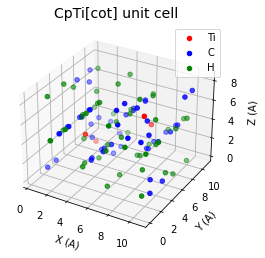

In [22]:
filename="ti.xyz"
xyz = open(filename)
#print(xyz.read()) #prints the hole file
n_atoms = int(xyz.readline())
#print(n_atoms) #number of atoms 
title = xyz.readline()
#print(title)
atoms=xyz

xh=[]
yh=[]
zh=[]
xt=[]
yt=[]
zt=[]
xc=[]
yc=[]
zc=[]
for line in xyz:
    
    atom, x,y,z = line.split()
    #Ti atoms
    if atom == 'Ti':
        xt.append(float(x))
        yt.append(float(y))
        zt.append(float(z))
    #Carbon atoms
    elif atom=='C':
        xc.append(float(x))
        yc.append(float(y))
        zc.append(float(z))
    #Hydrogen atoms
    else:
        xh.append(float(x))
        yh.append(float(y))
        zh.append(float(z))
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter3D(xt,yt,zt, c='r', marker='o', label='Ti')
ax.scatter3D(xc,yc,zc, c='b', marker='o', label='C')
ax.scatter3D(xh,yh,zh, c='green', marker='o', label='H')
ax.legend()
ax.set_xlabel('X (A)')
ax.set_ylabel('Y (A)')
ax.set_zlabel('Z (A)')

plt.title("CpTi[cot] unit cell", fontsize = 14) 

plt.show()

### Positions of the spins in the bath

Define the Simulator as a Class 

In [23]:
class Simulator:
    def __init__(spin, bath, r_bath, r_dipole, magnetic_field, order):
        spin.bath=bath
        spin.r_bath=r_bath
        spin.r_dipole = r_dipole
        spin.magnetic_field=magnetic_field
        spin.order=order
s1=Simulator(atoms, 40, 6, 500, 2)
print()
print("r_bath: ", s1.r_bath)
print("r_dipole: ", s1.r_dipole)
print("magnetic field: ", s1.magnetic_field)
print("order: ",s1.order)


r_bath:  40
r_dipole:  6
magnetic field:  500
order:  2


### Compute coherence function with conventional CCE

In [40]:
time_steps = np.linspace(0, 2, 101) #time points in ms at which the coherence function is computed
n=1 #pulses in Carr-Purcell-Meiboom-Gill (CPMG) sequence 
b=np.array([0,0,0]) #magnetic field along the z-axis Default=[0,0,0]

#use coherence function with conventional CCE
l_conv = calc.compute(time_steps, pulses=n, magnetic_field=b, method='cce', quantity='coherence', as_delay=False)


__as_delay__: True only if the points are delay between pulses, False if the time points are total time. Ignored if 'pulses' contains the time delays. _Type: Bool_

Define the time steps and calculate the coherence in those time steps

In [35]:
# parameters of calcuations
parameters = dict(
    order=2, # CCE order
    r_bath=40,  # Size of the bath in A
    r_dipole=6,  # Cutoff of pairwise clusters in A
    position=[0, 0, 0], # Position of central Spin
    pulses = 1, # N pulses in CPMG sequence
    magnetic_field=[0,0,0]
    
) 
time_space = time_steps



In [36]:
def runner(variable, values):
    invalue = parameters[variable]
    calc = pc.Simulator(spin=1, bath=atoms, **parameters)
    ls = []
    
    for v in values:
        setattr(calc,variable,v)
        l=calc.compute(time_space,method='cce', quantity='coherence')
        ls.append(l.real)
        
    parameters[variable]=invalue
    ls=pd.DataFrame(ls,columns=time_space,index=values).T
    return ls

<span style='background:yellow'> _Coments for Valerio_:  This are just for me to simulate the graphs of r_bath, r_dipole and order vs time, like the ones in: https://pycce.readthedocs.io/en/latest/tutorials/diamond_nv.html (similar to the image) but I keep getting a "StopIteration Error" and I don't know why :( I'm on it tho :D
  </span>

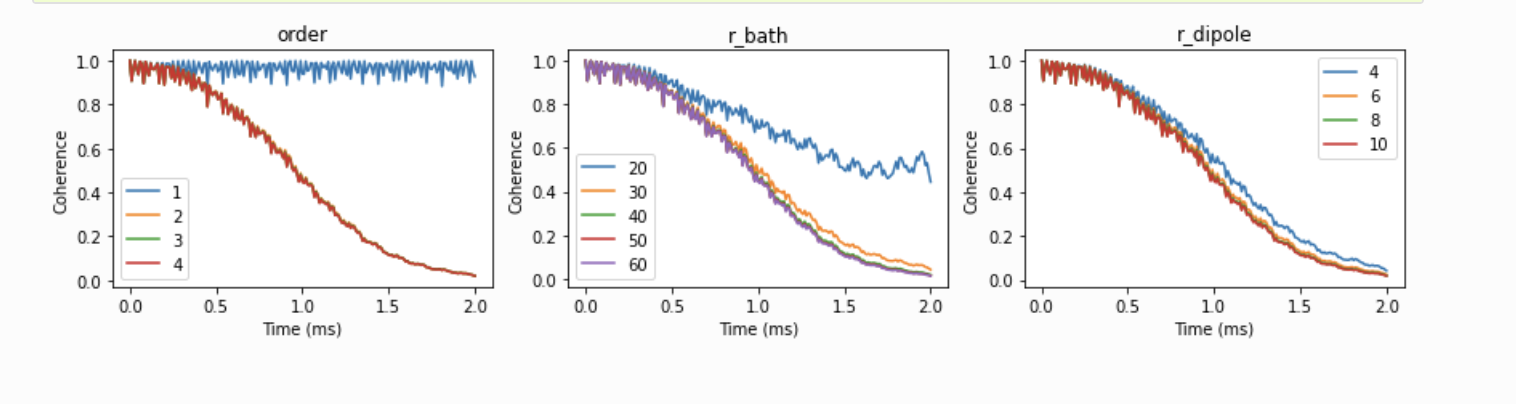

<span style='background:yellow'> 
    __StopIteration Error__ when trying to run theo rders, rbs and rds
    </span>

In [37]:
orders = runner('order', [1, 2, 3, 4])
rbs = runner('r_bath', [20, 30, 40, 50, 60])
rds = runner('r_dipole', [4, 6, 8, 10])

StopIteration: 